In [1]:
from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from more_itertools import flatten

In [3]:
import networkx as nx
import community

In [4]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
# net_df denotes a dataset that has had values prior to 1946 removed
mid_net_df = pd.read_pickle('Pickles/mid_net_df.pkl')
trade_net_df = pd.read_pickle('Pickles/trade_net_df.pkl')

In [7]:
trade_net_df.head()

,c_code_2,un_region_2,un_continent_2,c_code_1,un_region_1,un_continent_1,money_flow_1,money_flow_2,state_name_1,state_name_2,year
0,2.000,Northern America,Americas,20.000,Northern America,Americas,2038500000.000,1794000000.000,Canada,United States of America,1946
1,2.000,Northern America,Americas,20.000,Northern America,Americas,2038500000.000,1794000000.000,Canada,United States of America,1947
2,2.000,Northern America,Americas,20.000,Northern America,Americas,2038500000.000,1794000000.000,Canada,United States of America,1948
3,2.000,Northern America,Americas,20.000,Northern America,Americas,2101200000.000,1743000000.000,Canada,United States of America,1949
4,2.000,Northern America,Americas,20.000,Northern America,Americas,2162100000.000,2101000000.000,Canada,United States of America,1950


In [8]:
mid_net_df.head()

,dispute_id,c_code_1,state_name_abb_a,c_code_2,state_name_abb_b,year,outcome,settlement_type,total_fatality_bin,num_with,num_against,revision_sought,revision_type,state_fatality_bin,hostility_level,origin_participant,war,year_num,cumulative_duration,ongoing_2010,date_start,date_end,initiator,trade_yrs_before_mid,state_name_1,state_name_2
3544,1792,220,FRN,800,THI,1946,Stalemate,Negotiated,101-250,1,1,0,N/A,1-25,4,1,0,1,251,0,1946-04-01,1946-12-07,1.000,1.000,France,Thailand
3545,1792,800,THI,220,FRN,1946,Stalemate,Negotiated,101-250,1,1,0,N/A,101-250,4,1,0,1,251,0,1946-04-01,1946-12-07,0.000,1.000,Thailand,France
3546,2704,710,CHN,365,RUS,1946,Unclear,Unclear,None Value,1,1,0,N/A,None Value,1,1,0,2,211,0,1945-10-06,1946-05-03,0.000,74.000,China,Russia
3547,3192,200,UKG,345,YUG,1946,Stalemate,None Value,None Value,1,1,0,N/A,None Value,4,1,0,1,1,0,1946-10-05,1946-10-05,1.000,1.000,United Kingdom,Yugoslavia
3548,3192,345,YUG,200,UKG,1946,Stalemate,None Value,None Value,1,1,0,N/A,None Value,4,1,0,1,1,0,1946-10-05,1946-10-05,0.000,1.000,Yugoslavia,United Kingdom


Preparing Data for Network Analysis with NetworkX

In [9]:
df = pd.merge(trade_net_df, mid_net_df, how = 'inner', on = ['c_code_1', 'c_code_2', 'year'])

In [10]:
df.columns

Index(['c_code_2', 'un_region_2', 'un_continent_2', 'c_code_1', 'un_region_1',
       'un_continent_1', 'money_flow_1', 'money_flow_2', 'state_name_1_x',
       'state_name_2_x', 'year', 'dispute_id', 'state_name_abb_a',
       'state_name_abb_b', 'outcome', 'settlement_type', 'total_fatality_bin',
       'num_with', 'num_against', 'revision_sought', 'revision_type',
       'state_fatality_bin', 'hostility_level', 'origin_participant', 'war',
       'year_num', 'cumulative_duration', 'ongoing_2010', 'date_start',
       'date_end', 'initiator', 'trade_yrs_before_mid', 'state_name_1_y',
       'state_name_2_y'],
      dtype='object')

In [11]:
df.rename({'state_name_1_x': 'state_name_1', 'state_name_2_x': 'state_name_2'}, axis = 1, inplace = True)
df.drop(['state_name_1_y', 'state_name_2_y'], axis = 1, inplace = True)

print(len(df))

6250


In [12]:
aggregations = {'year': 'count'}

df_co_combos = df.groupby(['c_code_1', 'c_code_2']).agg(aggregations).reset_index()
df_co_combos['c_code_1'] = df_co_combos['c_code_1'].astype(int)
df_co_combos['c_code_2'] = df_co_combos['c_code_2'].astype(int)

column_list = ['money_flow_1', 'money_flow_2']
quad_list = ['money_flow_1', 'money_flow_2']

for c_code in df_co_combos[['c_code_1', 'c_code_2']].values:
    for column in column_list:
        data_list = list(df[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1])][column].values)
        if str(data_list).count('nan') == len(data_list):
            df.loc[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1]), column] = 0
        elif column not in quad_list and str(data_list).count('nan') <= len(data_list) - 2:
            df.loc[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1]), column] = df[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1])][column].interpolate()
        elif column in quad_list and str(data_list).count('nan') <= len(data_list) - 2:
            df.loc[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1]), column] = df[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1])][column].interpolate(method = 'quadratic')
        data_list = list(df[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1])][column].values)
        if str(data_list).count('nan') <= len(data_list) - 1:
            df.loc[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1]), column] = df[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1])][column].bfill()
            df.loc[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1]), column] = df[(df['c_code_1'] == c_code[0]) & (df['c_code_2'] == c_code[1])][column].ffill()

In [13]:
df['avg_money_flow'] = (df['money_flow_1'] + df['money_flow_2'])/2
df['avg_money_flow_log'] = np.log((df['money_flow_1'] + df['money_flow_2'])/2)
df['export_import_ratio'] = (df['money_flow_1'] / df['money_flow_2'])/2

In [14]:
df = df[df['avg_money_flow_log'].astype(str) != '-inf']
df = df.reset_index()
df.drop(['index'], axis = 1, inplace = True)

In [15]:
df.head()

,c_code_2,un_region_2,un_continent_2,c_code_1,un_region_1,un_continent_1,money_flow_1,money_flow_2,state_name_1,state_name_2,year,dispute_id,state_name_abb_a,state_name_abb_b,outcome,settlement_type,total_fatality_bin,num_with,num_against,revision_sought,revision_type,state_fatality_bin,hostility_level,origin_participant,war,year_num,cumulative_duration,ongoing_2010,date_start,date_end,initiator,trade_yrs_before_mid,avg_money_flow,avg_money_flow_log,export_import_ratio
0,2.000,Northern America,Americas,20.000,Northern America,Americas,42467700000.000,38970400000.000,Canada,United States of America,1979,2968,CAN,USA,Stalemate,None Value,None Value,1,1,1,Policy,None Value,4,1,0,1,4,0,1979-08-28,1979-08-31,1.000,58.000,40719050000.000,24.430,0.545
1,2.000,Northern America,Americas,20.000,Northern America,Americas,82004400000.000,89550200000.000,Canada,United States of America,1989,3900,CAN,USA,Stalemate,None Value,None Value,1,1,0,N/A,None Value,3,1,0,1,1,0,1989-12-11,1989-12-11,1.000,68.000,85777300000.000,25.175,0.458
2,2.000,Northern America,Americas,20.000,Northern America,Americas,82527600000.000,93736100000.000,Canada,United States of America,1991,3972,CAN,USA,Released (for seizures),None Value,None Value,1,1,0,N/A,None Value,1,1,0,1,1,0,1991-07-29,1991-07-29,0.000,70.000,88131850000.000,25.202,0.440
3,2.000,Northern America,Americas,20.000,Northern America,Americas,145143000000.000,171440000000.000,Canada,United States of America,1997,4183,CAN,USA,Released (for seizures),Negotiated,None Value,1,1,1,Policy,None Value,4,1,0,1,4,0,1997-05-25,1997-05-28,1.000,76.000,158291500000.000,25.788,0.423
4,2.000,Northern America,Americas,40.000,Caribbean,Americas,225000000.000,389000000.000,Cuba,United States of America,1960,246,CUB,USA,N/A,N/A,None Value,2,1,0,N/A,None Value,4,1,0,1,254,0,1960-04-22,1961-04-26,1.000,50.000,307000000.000,19.542,0.289


In [16]:
df.loc[(df['avg_money_flow'] >= 50000000), 'avg_money_flow_bin'] = 3
df.loc[(df['avg_money_flow'] > 2500000) & (df['avg_money_flow'] < 50000000), 'avg_money_flow_bin'] = 2
df.loc[(df['avg_money_flow'] <= 2500000), 'avg_money_flow_bin'] = 1
df['avg_money_flow_bin'] = df['avg_money_flow_bin'].astype(int)

In [17]:
df['avg_money_flow_bin'].value_counts()

3    2031
2    2002
1    1985
Name: avg_money_flow_bin, dtype: int64

In [18]:
len(df['state_name_1'].unique())

175

In [19]:
combo_df = deepcopy(df[['state_name_1', 'state_name_2', 'year', 'date_start', 'money_flow_1', 'money_flow_2', 'avg_money_flow', 'avg_money_flow_log', 'export_import_ratio', 'cumulative_duration']])

In [20]:
aggregations = {
    'date_start': 'count',
    'avg_money_flow': 'mean',
    'avg_money_flow_log': 'mean',
    'money_flow_1': 'mean',
    'money_flow_2': 'mean',
    'export_import_ratio': 'mean',
    'cumulative_duration': 'sum'
    }

combo_df_group = combo_df.groupby(['year', 'state_name_1', 'state_name_2']).agg(aggregations).reset_index()

aggregations = {
    'date_start': 'sum',
    'year': 'count',
    'avg_money_flow': 'mean',
    'avg_money_flow_log': 'mean',
    'money_flow_1': 'mean',
    'money_flow_2': 'mean',
    'export_import_ratio': 'mean',
    'cumulative_duration': 'sum'
    }

combo_df_group = combo_df_group.groupby(['state_name_1', 'state_name_2']).agg(aggregations).reset_index()

In [21]:
combo_df_group.head()

,state_name_1,state_name_2,date_start,year,avg_money_flow,avg_money_flow_log,money_flow_1,money_flow_2,export_import_ratio,cumulative_duration
0,Afghanistan,Australia,1,1,215000.000,12.278,410000.000,20000.000,10.250,77
1,Afghanistan,Canada,1,1,205000.000,12.231,110000.000,300000.000,0.183,77
2,Afghanistan,France,1,1,2825000.000,14.854,5230000.000,420000.000,6.226,99
3,Afghanistan,Germany,1,1,11580000.000,16.265,15940000.000,7220000.000,1.104,23
4,Afghanistan,Greece,1,1,175000.000,12.073,330000.000,20000.000,8.250,23


In [22]:
for i, combo in enumerate(combo_df_group['state_name_1']):
    combo_df_group.loc[i, 'treaties_per_year'] = combo_df_group['date_start'][i]/combo_df_group['year'][i]
combo_df_group.rename({'year': 'num_years'}, axis = 1, inplace = True)
combo_df_group.drop(['date_start'], axis = 1, inplace = True)

In [23]:
combo_df_group.loc[(combo_df_group['avg_money_flow'] >= 50000000), 'avg_money_flow_bin'] = 3
combo_df_group.loc[(combo_df_group['avg_money_flow'] > 2500000) & (combo_df_group['avg_money_flow'] < 50000000), 'avg_money_flow_bin'] = 2
combo_df_group.loc[(combo_df_group['avg_money_flow'] <= 2500000), 'avg_money_flow_bin'] = 1
combo_df_group['avg_money_flow_bin'] = combo_df_group['avg_money_flow_bin'].astype(int)

In [24]:
combo_df_group['avg_money_flow_bin'].value_counts()

3    397
2    384
1    355
Name: avg_money_flow_bin, dtype: int64

In [25]:
combo_df_group['num_years'].unique()

array([ 1,  9,  2, 25, 13,  5,  6,  3, 10,  8, 14, 18,  4, 17, 35,  7, 12,
       11, 24, 19, 31, 15, 37, 29, 46, 38, 21, 26, 16, 27, 54, 40])

In [26]:
combo_df_group.head()

,state_name_1,state_name_2,num_years,avg_money_flow,avg_money_flow_log,money_flow_1,money_flow_2,export_import_ratio,cumulative_duration,treaties_per_year,avg_money_flow_bin
0,Afghanistan,Australia,1,215000.000,12.278,410000.000,20000.000,10.250,77,1.000,1
1,Afghanistan,Canada,1,205000.000,12.231,110000.000,300000.000,0.183,77,1.000,1
2,Afghanistan,France,1,2825000.000,14.854,5230000.000,420000.000,6.226,99,1.000,2
3,Afghanistan,Germany,1,11580000.000,16.265,15940000.000,7220000.000,1.104,23,1.000,2
4,Afghanistan,Greece,1,175000.000,12.073,330000.000,20000.000,8.250,23,1.000,1


In [27]:
dist_combo_df = deepcopy(df[['state_name_1', 'state_name_2']])

duplicate_list = ['state_name_1', 'state_name_2']

dist_combo_df.drop_duplicates(subset = duplicate_list, keep = 'first', inplace = True)
dist_combo_df = dist_combo_df.reset_index()
dist_combo_df.drop(['index'], axis = 1, inplace = True)

In [28]:
dist_combos = []
for i, row in enumerate(dist_combo_df['state_name_1']):
    dist_combos.append((dist_combo_df['state_name_1'][i], dist_combo_df['state_name_2'][i]))
dist_combos = sorted(dist_combos)

print(len(dist_combos))

1136


In [29]:
dist_countries = []
for i in flatten(dist_combos):
    dist_countries.append(i)
dist_countries = sorted(list(set(dist_countries)))

print(len(dist_countries))

175


Full Network with Networkx

In [30]:
country_graph = nx.Graph()

In [31]:
combo_df_group.columns

Index(['state_name_1', 'state_name_2', 'num_years', 'avg_money_flow',
       'avg_money_flow_log', 'money_flow_1', 'money_flow_2',
       'export_import_ratio', 'cumulative_duration', 'treaties_per_year',
       'avg_money_flow_bin'],
      dtype='object')

In [32]:
for country_a, country_b in dist_combos:
    country_a_label = country_a.replace(' ', '\n')
    country_b_label = country_b.replace(' ', '\n')
#     treaties_per_year = 1000 * (int(combo_df_group[(combo_df_group['state_name_1'] == country_a) & (combo_df_group['state_name_2'] == country_b)]['treaties_per_year'].values[0]))
    avg_money_flow_log = combo_df_group[(combo_df_group['state_name_1'] == country_a) & (combo_df_group['state_name_2'] == country_b)]['avg_money_flow_log'].values[0]
    country_graph.add_edge(country_a_label, country_b_label, weight = avg_money_flow_log)

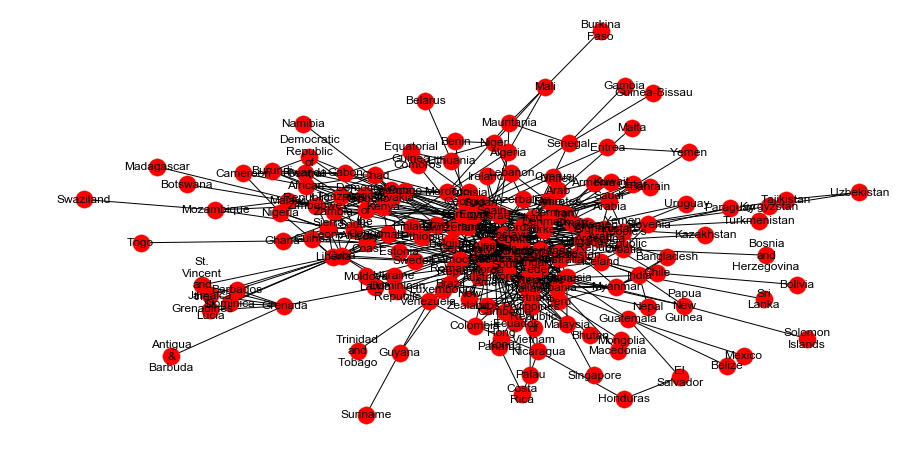

In [33]:
filterwarnings('ignore')

plt.style.use('seaborn')
plt.figure(figsize = (12, 6))

positions = nx.spring_layout(country_graph)
network = nx.draw(country_graph, pos = positions)
labels = nx.draw_networkx_labels(country_graph, pos = positions)
nx.write_gexf(country_graph, "Other/Gephi/non_dist_combos_deg_1.gexf")

In [34]:
nx.number_of_nodes(country_graph)

175

Network From One Country's Perspective (Up to Second Degree)

In [35]:
input_country = 'United States of America'
combo_deg_1 = list(filter(lambda country: input_country in country, dist_combos))

print(len(combo_deg_1))

90


In [36]:
node_deg_1 = []
for a, b in combo_deg_1:
    node_deg_1.append(a)
    node_deg_1.append(b)
node_deg_1 = sorted(list(set(node_deg_1)))

print(len(node_deg_1))

46


In [37]:
non_dist_combos_deg_1 = []
for a, b in combo_deg_1:
    for country in node_deg_1:
        if country == a:
            non_dist_combos_deg_1.append((a, b))
        elif country == b:
            non_dist_combos_deg_1.append((a, b))
non_dist_combos_deg_1 = sorted(non_dist_combos_deg_1)

print(len(non_dist_combos_deg_1))

180


In [38]:
for i, combo in enumerate(combo_df_group['state_name_1']):
    for z, connection in enumerate(non_dist_combos_deg_1):
        if non_dist_combos_deg_1[z][0] == combo and non_dist_combos_deg_1[z][1] == combo_df_group['state_name_2'][i]:
            combo_df_group.loc[i, 'non_dist_combo'] = 'Yes'
            
non_dist_combos_deg_1_df = combo_df_group[combo_df_group['non_dist_combo'] == 'Yes']
combo_df_group.drop(['non_dist_combo'], axis = 1, inplace = True)
non_dist_combos_deg_1_df = non_dist_combos_deg_1_df.reset_index()
non_dist_combos_deg_1_df.drop(['index', 'non_dist_combo'], axis = 1, inplace = True)

In [39]:
non_dist_combos_deg_1_counter = Counter(non_dist_combos_deg_1)

In [40]:
for i, combo in enumerate(combo_df_group['state_name_1']):
    for connection in combo_deg_1:
        if connection[0] == combo and connection[1] == combo_df_group['state_name_2'][i]:
            combo_df_group.loc[i, 'combo_deg_1'] = 'Yes'
            
combo_deg_1_df = combo_df_group[combo_df_group['combo_deg_1'] == 'Yes'].reset_index()
combo_deg_1_df.drop(['index', 'combo_deg_1'], axis = 1, inplace = True)

combo_deg_1_df = combo_deg_1_df[combo_deg_1_df['state_name_1'] == input_country].reset_index()
combo_deg_1_df.drop(['index'], axis = 1, inplace = True)

In [41]:
combo_deg_1_counter = Counter(combo_deg_1)

In [42]:
network_nodes = []
for country_a, country_b in combo_deg_1:
    network_nodes.append(country_a)
    network_nodes.append(country_b)
network_nodes = sorted(list(set(network_nodes)))

print(len(network_nodes))
print(len(combo_deg_1_df))

46
45


In [43]:
c_deg_1_graph = nx.Graph()

In [44]:
combo_deg_1_df['num_years'].unique()

array([ 2,  1,  7,  4, 31, 13,  8,  5,  3, 17, 18, 10, 40, 35, 12,  9])

In [45]:
combo_deg_1_df.head()

,state_name_1,state_name_2,num_years,avg_money_flow,avg_money_flow_log,money_flow_1,money_flow_2,export_import_ratio,cumulative_duration,treaties_per_year,avg_money_flow_bin
0,United States of America,Afghanistan,2,8122500.000,15.730,9150000.000,7095000.000,0.606,100,1.000,2
1,United States of America,Albania,1,1000000.000,13.816,1000000.000,1000000.000,0.500,4,1.000,1
2,United States of America,Austria,1,78500000.000,18.179,53000000.000,104000000.000,0.255,1,1.000,3
3,United States of America,Bulgaria,1,1000000.000,13.816,1000000.000,1000000.000,0.500,223,1.000,1
4,United States of America,Cambodia,7,7235714.286,15.177,2285714.286,12185714.286,0.329,1106,1.000,2


In [46]:
for country_a, country_b in combo_deg_1:
    country_a_label = country_a.replace(' ', '\n')
    country_b_label = country_b.replace(' ', '\n')
#     treaties_per_year = 1000 * (int(combo_df_group[(combo_df_group['state_name_1'] == country_a) & (combo_df_group['state_name_2'] == country_b)]['treaties_per_year'].values[0]))
#     avg_money_flow_log = combo_df_group[(combo_df_group['state_name_1'] == country_a) & (combo_df_group['state_name_2'] == country_b)]['avg_money_flow_log'].values[0]
    avg_money_flow_bin = combo_df_group[(combo_df_group['state_name_1'] == country_a) & (combo_df_group['state_name_2'] == country_b)]['avg_money_flow_bin'].values[0]
    conflict_length = int(combo_df_group[(combo_df_group['state_name_1'] == country_a) & (combo_df_group['state_name_2'] == country_b)]['num_years'].values[0])
    c_deg_1_graph.add_edge(country_a_label, country_b_label, weight = avg_money_flow_bin, length = conflict_length)

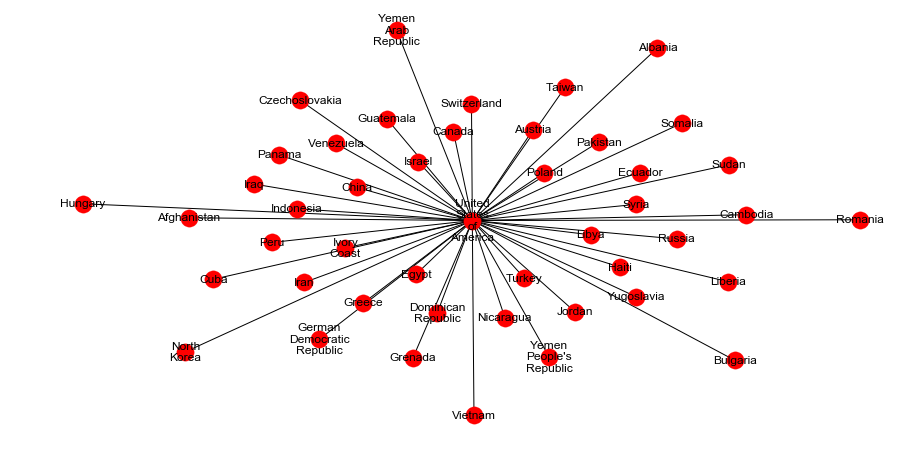

In [47]:
filterwarnings('ignore')

plt.style.use('seaborn')
plt.figure(figsize = (12, 6))

positions = nx.spring_layout(c_deg_1_graph)
network = nx.draw(c_deg_1_graph, pos = positions)
labels = nx.draw_networkx_labels(c_deg_1_graph, pos = positions)
nx.write_gexf(c_deg_1_graph, "Other/Gephi/c_deg_1_graph.gexf")

In [48]:
nx.number_of_nodes(c_deg_1_graph)

46

In [49]:
# graph_file = open("d3/network.json", 'w+')

# json_dic = {}
# json_dic['nodes'] = {}
# json_dic['links'] = {}
# start_line = '{\n  "nodes": [\n'
# middle_line = '  ],\n  "links": [\n'
# end_line = '\n  ]\n}'

# graph_file.write(start_line)
# for i, node in enumerate(network_nodes):
#     if node == network_nodes[-1]:
#         add_line = '    {"country": "' + node + '", "size": ' + str(non_dist_combos_deg_1_df[(non_dist_combos_deg_1_df['state_name_1'] == node) | (non_dist_combos_deg_1_df['state_name_2'] == node)]['avg_money_flow_log'].mean()) + '}\n'
#         graph_file.write(add_line)
#     else:
#         add_line = '    {"country": "' + node + '", "size": ' + str(non_dist_combos_deg_1_df[(non_dist_combos_deg_1_df['state_name_1'] == node) | (non_dist_combos_deg_1_df['state_name_2'] == node)]['avg_money_flow_log'].mean()) + '},\n'
#         graph_file.write(add_line)        

# graph_file.write(middle_line)

# node_count = 0
# for node_1, node_2 in non_dist_combos_deg_1:
#     node_count+=1
#     bond = non_dist_combos_deg_1_counter[(node_1, node_2)]
#     if node_count != len(non_dist_combos_deg_1):
#         add_line = '    {"source": ' + str(network_nodes.index(node_1)) + ', "target": ' + str(network_nodes.index(node_2)) + ', "bond": ' + str(bond) + '},\n'
#         graph_file.write(add_line)
#     else:
#         add_line = '    {"source": ' + str(network_nodes.index(node_1)) + ', "target": ' + str(network_nodes.index(node_2)) + ', "bond": ' + str(bond) + '}\n'
#         graph_file.write(add_line)

# graph_file.write(end_line)

In [50]:
# for country_a, country_b in dist_combos:
#     country_a_label = country_a.replace(' ', '\n')
#     country_b_label = country_b.replace(' ', '\n')
#     treaties_per_year = 1000 * (int(combo_df_group[(combo_df_group['state_name_1'] == country_a) & (combo_df_group['state_name_2'] == country_b)]['treaties_per_year'].values[0]))
#     country_graph.add_edge(country_a_label, country_b_label, weight = treaties_per_year)